In [1]:
import logging

import probtorch
import torch

import combinators
import foldable
import importance
import mcmc
import ssm
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0.0

In [4]:
ssm_initializer = combinators.Deterministic(zs[0], mu, sigma, delta, batch_shape=tuple())
ssm_step = foldable.Foldable(ssm.SsmStep(batch_shape=tuple()), initializer=ssm_initializer)
ssm_sequence = foldable.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1))

In [5]:
_, generative, _ = ssm_sequence()

In [6]:
data = {k: v.value for k, v in generative.variables() if 'X_' in k}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(1.),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(1.),
    },
    'delta': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(1.),
    }
}

In [9]:
init_ssm_generative = ssm.InitSsm(params=ssm_params, trainable=False, batch_shape=particle_shape)
init_ssm_proposal = ssm.InitSsm(params=ssm_params, trainable=True, batch_shape=particle_shape)
init_ssm_training = combinators.GuidedConditioning(init_ssm_generative, init_ssm_proposal)

In [10]:
ssm_step_training = foldable.Foldable(ssm.SsmStep(batch_shape=particle_shape), initializer=init_ssm_training)
ssm_training = foldable.Reduce(ssm_step_training, lambda: range(50))

In [11]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_training, 2000, data, use_cuda=False,
    lr=1e-2, patience=100
)

02/08/2019 13:41:20 ELBO=-6.39367126e+02 at epoch 1
02/08/2019 13:41:20 ELBO=-7.00180359e+02 at epoch 2
02/08/2019 13:41:21 ELBO=-6.81984924e+02 at epoch 3
02/08/2019 13:41:21 ELBO=-6.58746094e+02 at epoch 4
02/08/2019 13:41:21 ELBO=-7.22355103e+02 at epoch 5
02/08/2019 13:41:21 ELBO=-1.14119885e+03 at epoch 6
02/08/2019 13:41:21 ELBO=-6.66907959e+02 at epoch 7
02/08/2019 13:41:21 ELBO=-6.05012146e+02 at epoch 8
02/08/2019 13:41:21 ELBO=-6.43637268e+02 at epoch 9
02/08/2019 13:41:21 ELBO=-6.40693542e+02 at epoch 10
02/08/2019 13:41:21 ELBO=-6.82265259e+02 at epoch 11
02/08/2019 13:41:21 ELBO=-6.90618286e+02 at epoch 12
02/08/2019 13:41:21 ELBO=-6.14323547e+02 at epoch 13
02/08/2019 13:41:21 ELBO=-8.11334167e+02 at epoch 14
02/08/2019 13:41:21 ELBO=-7.63317749e+02 at epoch 15
02/08/2019 13:41:21 ELBO=-6.72326416e+02 at epoch 16
02/08/2019 13:41:22 ELBO=-6.19779297e+02 at epoch 17
02/08/2019 13:41:22 ELBO=-6.84204773e+02 at epoch 18
02/08/2019 13:41:22 ELBO=-7.34541443e+02 at epoch 19
02

Epoch   384: reducing learning rate of group 0 to 5.0000e-03.


02/08/2019 13:41:43 ELBO=-5.41559937e+02 at epoch 390
02/08/2019 13:41:43 ELBO=-5.50218384e+02 at epoch 391
02/08/2019 13:41:43 ELBO=-5.42563660e+02 at epoch 392
02/08/2019 13:41:43 ELBO=-5.13499939e+02 at epoch 393
02/08/2019 13:41:44 ELBO=-5.12332092e+02 at epoch 394
02/08/2019 13:41:44 ELBO=-5.98723999e+02 at epoch 395
02/08/2019 13:41:44 ELBO=-5.14635437e+02 at epoch 396
02/08/2019 13:41:44 ELBO=-5.44136169e+02 at epoch 397
02/08/2019 13:41:44 ELBO=-5.36841980e+02 at epoch 398
02/08/2019 13:41:44 ELBO=-5.68865356e+02 at epoch 399
02/08/2019 13:41:44 ELBO=-5.12425903e+02 at epoch 400
02/08/2019 13:41:44 ELBO=-4.85285034e+02 at epoch 401
02/08/2019 13:41:44 ELBO=-5.29417419e+02 at epoch 402
02/08/2019 13:41:44 ELBO=-5.27665527e+02 at epoch 403
02/08/2019 13:41:44 ELBO=-5.01580597e+02 at epoch 404
02/08/2019 13:41:44 ELBO=-5.11309113e+02 at epoch 405
02/08/2019 13:41:44 ELBO=-5.12272400e+02 at epoch 406
02/08/2019 13:41:44 ELBO=-7.01237305e+02 at epoch 407
02/08/2019 13:41:44 ELBO=-5.

Epoch   535: reducing learning rate of group 0 to 2.5000e-03.


02/08/2019 13:41:52 ELBO=-5.57272400e+02 at epoch 539
02/08/2019 13:41:52 ELBO=-6.30624268e+02 at epoch 540
02/08/2019 13:41:52 ELBO=-5.30036499e+02 at epoch 541
02/08/2019 13:41:52 ELBO=-5.43016296e+02 at epoch 542
02/08/2019 13:41:52 ELBO=-4.81122864e+02 at epoch 543
02/08/2019 13:41:52 ELBO=-5.26229797e+02 at epoch 544
02/08/2019 13:41:52 ELBO=-5.82586792e+02 at epoch 545
02/08/2019 13:41:52 ELBO=-5.11372162e+02 at epoch 546
02/08/2019 13:41:52 ELBO=-5.02071655e+02 at epoch 547
02/08/2019 13:41:53 ELBO=-4.95509521e+02 at epoch 548
02/08/2019 13:41:53 ELBO=-4.93931335e+02 at epoch 549
02/08/2019 13:41:53 ELBO=-5.14371887e+02 at epoch 550
02/08/2019 13:41:53 ELBO=-5.11808350e+02 at epoch 551
02/08/2019 13:41:53 ELBO=-5.17333191e+02 at epoch 552
02/08/2019 13:41:53 ELBO=-5.29338867e+02 at epoch 553
02/08/2019 13:41:53 ELBO=-4.92443573e+02 at epoch 554
02/08/2019 13:41:53 ELBO=-5.48894043e+02 at epoch 555
02/08/2019 13:41:53 ELBO=-5.24250671e+02 at epoch 556
02/08/2019 13:41:53 ELBO=-5.

Epoch   636: reducing learning rate of group 0 to 1.2500e-03.


02/08/2019 13:41:58 ELBO=-5.83914429e+02 at epoch 641
02/08/2019 13:41:58 ELBO=-4.99221710e+02 at epoch 642
02/08/2019 13:41:58 ELBO=-5.09788757e+02 at epoch 643
02/08/2019 13:41:58 ELBO=-5.20396362e+02 at epoch 644
02/08/2019 13:41:58 ELBO=-5.14001770e+02 at epoch 645
02/08/2019 13:41:58 ELBO=-5.02722168e+02 at epoch 646
02/08/2019 13:41:59 ELBO=-5.17046204e+02 at epoch 647
02/08/2019 13:41:59 ELBO=-5.01536987e+02 at epoch 648
02/08/2019 13:41:59 ELBO=-5.12961548e+02 at epoch 649
02/08/2019 13:41:59 ELBO=-5.05668915e+02 at epoch 650
02/08/2019 13:41:59 ELBO=-5.71265503e+02 at epoch 651
02/08/2019 13:41:59 ELBO=-5.04130188e+02 at epoch 652
02/08/2019 13:41:59 ELBO=-4.98087708e+02 at epoch 653
02/08/2019 13:41:59 ELBO=-5.46594666e+02 at epoch 654
02/08/2019 13:41:59 ELBO=-5.17578979e+02 at epoch 655
02/08/2019 13:41:59 ELBO=-4.92401215e+02 at epoch 656
02/08/2019 13:41:59 ELBO=-5.12087219e+02 at epoch 657
02/08/2019 13:41:59 ELBO=-4.97319458e+02 at epoch 658
02/08/2019 13:41:59 ELBO=-5.

Epoch   737: reducing learning rate of group 0 to 6.2500e-04.


02/08/2019 13:42:04 ELBO=-5.14285583e+02 at epoch 742
02/08/2019 13:42:04 ELBO=-4.88242157e+02 at epoch 743
02/08/2019 13:42:05 ELBO=-5.00265259e+02 at epoch 744
02/08/2019 13:42:05 ELBO=-5.17207520e+02 at epoch 745
02/08/2019 13:42:05 ELBO=-5.06696655e+02 at epoch 746
02/08/2019 13:42:05 ELBO=-5.06310730e+02 at epoch 747
02/08/2019 13:42:05 ELBO=-4.89150146e+02 at epoch 748
02/08/2019 13:42:05 ELBO=-6.07098816e+02 at epoch 749
02/08/2019 13:42:05 ELBO=-5.28984924e+02 at epoch 750
02/08/2019 13:42:05 ELBO=-5.24339905e+02 at epoch 751
02/08/2019 13:42:05 ELBO=-5.09784821e+02 at epoch 752
02/08/2019 13:42:05 ELBO=-5.08408264e+02 at epoch 753
02/08/2019 13:42:05 ELBO=-5.40036011e+02 at epoch 754
02/08/2019 13:42:05 ELBO=-5.11356964e+02 at epoch 755
02/08/2019 13:42:05 ELBO=-4.87496643e+02 at epoch 756
02/08/2019 13:42:05 ELBO=-5.27614197e+02 at epoch 757
02/08/2019 13:42:05 ELBO=-4.96794617e+02 at epoch 758
02/08/2019 13:42:05 ELBO=-5.50362122e+02 at epoch 759
02/08/2019 13:42:05 ELBO=-4.

Epoch   838: reducing learning rate of group 0 to 3.1250e-04.


02/08/2019 13:42:10 ELBO=-4.95271454e+02 at epoch 844
02/08/2019 13:42:10 ELBO=-5.40849792e+02 at epoch 845
02/08/2019 13:42:10 ELBO=-5.15130554e+02 at epoch 846
02/08/2019 13:42:10 ELBO=-5.26237610e+02 at epoch 847
02/08/2019 13:42:10 ELBO=-5.03908142e+02 at epoch 848
02/08/2019 13:42:10 ELBO=-5.25612122e+02 at epoch 849
02/08/2019 13:42:10 ELBO=-5.32860413e+02 at epoch 850
02/08/2019 13:42:10 ELBO=-4.92425293e+02 at epoch 851
02/08/2019 13:42:10 ELBO=-5.17836609e+02 at epoch 852
02/08/2019 13:42:10 ELBO=-5.25724060e+02 at epoch 853
02/08/2019 13:42:10 ELBO=-5.20255005e+02 at epoch 854
02/08/2019 13:42:10 ELBO=-5.65345337e+02 at epoch 855
02/08/2019 13:42:10 ELBO=-5.63728638e+02 at epoch 856
02/08/2019 13:42:10 ELBO=-5.20637085e+02 at epoch 857
02/08/2019 13:42:10 ELBO=-5.49230164e+02 at epoch 858
02/08/2019 13:42:10 ELBO=-4.95858459e+02 at epoch 859
02/08/2019 13:42:10 ELBO=-5.33825684e+02 at epoch 860
02/08/2019 13:42:11 ELBO=-5.00165558e+02 at epoch 861
02/08/2019 13:42:11 ELBO=-4.

Epoch   939: reducing learning rate of group 0 to 1.5625e-04.


02/08/2019 13:42:15 ELBO=-5.13859436e+02 at epoch 945
02/08/2019 13:42:15 ELBO=-5.11149963e+02 at epoch 946
02/08/2019 13:42:15 ELBO=-5.45300171e+02 at epoch 947
02/08/2019 13:42:15 ELBO=-5.32414001e+02 at epoch 948
02/08/2019 13:42:15 ELBO=-5.81796326e+02 at epoch 949
02/08/2019 13:42:15 ELBO=-5.12657654e+02 at epoch 950
02/08/2019 13:42:15 ELBO=-5.30357056e+02 at epoch 951
02/08/2019 13:42:15 ELBO=-5.37991211e+02 at epoch 952
02/08/2019 13:42:15 ELBO=-5.45455383e+02 at epoch 953
02/08/2019 13:42:15 ELBO=-4.89103424e+02 at epoch 954
02/08/2019 13:42:15 ELBO=-5.25413757e+02 at epoch 955
02/08/2019 13:42:15 ELBO=-5.46453796e+02 at epoch 956
02/08/2019 13:42:15 ELBO=-5.55746033e+02 at epoch 957
02/08/2019 13:42:15 ELBO=-5.11787964e+02 at epoch 958
02/08/2019 13:42:15 ELBO=-5.79568787e+02 at epoch 959
02/08/2019 13:42:15 ELBO=-5.14622681e+02 at epoch 960
02/08/2019 13:42:15 ELBO=-5.52065308e+02 at epoch 961
02/08/2019 13:42:16 ELBO=-5.41478455e+02 at epoch 962
02/08/2019 13:42:16 ELBO=-5.

Epoch  1114: reducing learning rate of group 0 to 7.8125e-05.


02/08/2019 13:42:24 ELBO=-5.19515808e+02 at epoch 1120
02/08/2019 13:42:24 ELBO=-5.09345764e+02 at epoch 1121
02/08/2019 13:42:24 ELBO=-5.85809937e+02 at epoch 1122
02/08/2019 13:42:24 ELBO=-4.97971619e+02 at epoch 1123
02/08/2019 13:42:24 ELBO=-5.43322998e+02 at epoch 1124
02/08/2019 13:42:24 ELBO=-5.31888367e+02 at epoch 1125
02/08/2019 13:42:24 ELBO=-5.08648438e+02 at epoch 1126
02/08/2019 13:42:24 ELBO=-4.89221161e+02 at epoch 1127
02/08/2019 13:42:24 ELBO=-4.87407349e+02 at epoch 1128
02/08/2019 13:42:24 ELBO=-4.93260925e+02 at epoch 1129
02/08/2019 13:42:24 ELBO=-4.97737518e+02 at epoch 1130
02/08/2019 13:42:24 ELBO=-5.13698425e+02 at epoch 1131
02/08/2019 13:42:24 ELBO=-4.96466888e+02 at epoch 1132
02/08/2019 13:42:24 ELBO=-5.01694122e+02 at epoch 1133
02/08/2019 13:42:24 ELBO=-5.06560394e+02 at epoch 1134
02/08/2019 13:42:24 ELBO=-5.29984436e+02 at epoch 1135
02/08/2019 13:42:24 ELBO=-5.90799805e+02 at epoch 1136
02/08/2019 13:42:24 ELBO=-4.89584381e+02 at epoch 1137
02/08/2019

Epoch  1215: reducing learning rate of group 0 to 3.9063e-05.


02/08/2019 13:42:29 ELBO=-4.92655884e+02 at epoch 1220
02/08/2019 13:42:29 ELBO=-5.10477173e+02 at epoch 1221
02/08/2019 13:42:29 ELBO=-5.54339050e+02 at epoch 1222
02/08/2019 13:42:29 ELBO=-5.03459412e+02 at epoch 1223
02/08/2019 13:42:29 ELBO=-5.33958008e+02 at epoch 1224
02/08/2019 13:42:29 ELBO=-5.06117279e+02 at epoch 1225
02/08/2019 13:42:29 ELBO=-5.14361389e+02 at epoch 1226
02/08/2019 13:42:29 ELBO=-5.14976868e+02 at epoch 1227
02/08/2019 13:42:29 ELBO=-5.26943848e+02 at epoch 1228
02/08/2019 13:42:29 ELBO=-4.86973755e+02 at epoch 1229
02/08/2019 13:42:29 ELBO=-4.84422760e+02 at epoch 1230
02/08/2019 13:42:29 ELBO=-5.33488037e+02 at epoch 1231
02/08/2019 13:42:29 ELBO=-4.89542969e+02 at epoch 1232
02/08/2019 13:42:29 ELBO=-5.64523132e+02 at epoch 1233
02/08/2019 13:42:29 ELBO=-5.20802734e+02 at epoch 1234
02/08/2019 13:42:29 ELBO=-4.92804932e+02 at epoch 1235
02/08/2019 13:42:29 ELBO=-5.03171600e+02 at epoch 1236
02/08/2019 13:42:29 ELBO=-5.79515137e+02 at epoch 1237
02/08/2019

Epoch  1316: reducing learning rate of group 0 to 1.9531e-05.


02/08/2019 13:42:34 ELBO=-4.88395782e+02 at epoch 1322
02/08/2019 13:42:34 ELBO=-5.05275879e+02 at epoch 1323
02/08/2019 13:42:34 ELBO=-5.29936707e+02 at epoch 1324
02/08/2019 13:42:34 ELBO=-4.88426239e+02 at epoch 1325
02/08/2019 13:42:34 ELBO=-4.83789612e+02 at epoch 1326
02/08/2019 13:42:34 ELBO=-4.96696716e+02 at epoch 1327
02/08/2019 13:42:34 ELBO=-5.49272156e+02 at epoch 1328
02/08/2019 13:42:34 ELBO=-5.39877014e+02 at epoch 1329
02/08/2019 13:42:34 ELBO=-5.02476410e+02 at epoch 1330
02/08/2019 13:42:34 ELBO=-4.99703217e+02 at epoch 1331
02/08/2019 13:42:34 ELBO=-4.89426666e+02 at epoch 1332
02/08/2019 13:42:34 ELBO=-4.97359467e+02 at epoch 1333
02/08/2019 13:42:34 ELBO=-5.35197083e+02 at epoch 1334
02/08/2019 13:42:34 ELBO=-4.99163269e+02 at epoch 1335
02/08/2019 13:42:35 ELBO=-4.95762909e+02 at epoch 1336
02/08/2019 13:42:35 ELBO=-5.03197723e+02 at epoch 1337
02/08/2019 13:42:35 ELBO=-4.88528259e+02 at epoch 1338
02/08/2019 13:42:35 ELBO=-4.91705994e+02 at epoch 1339
02/08/2019

Epoch  1417: reducing learning rate of group 0 to 9.7656e-06.


02/08/2019 13:42:39 ELBO=-5.00879150e+02 at epoch 1423
02/08/2019 13:42:39 ELBO=-5.01550964e+02 at epoch 1424
02/08/2019 13:42:39 ELBO=-5.09239807e+02 at epoch 1425
02/08/2019 13:42:39 ELBO=-5.04150909e+02 at epoch 1426
02/08/2019 13:42:39 ELBO=-5.49437561e+02 at epoch 1427
02/08/2019 13:42:39 ELBO=-5.10893311e+02 at epoch 1428
02/08/2019 13:42:39 ELBO=-5.95719116e+02 at epoch 1429
02/08/2019 13:42:39 ELBO=-5.18752441e+02 at epoch 1430
02/08/2019 13:42:39 ELBO=-5.25176270e+02 at epoch 1431
02/08/2019 13:42:39 ELBO=-4.98332184e+02 at epoch 1432
02/08/2019 13:42:39 ELBO=-5.40349487e+02 at epoch 1433
02/08/2019 13:42:40 ELBO=-5.14204712e+02 at epoch 1434
02/08/2019 13:42:40 ELBO=-5.32847351e+02 at epoch 1435
02/08/2019 13:42:40 ELBO=-4.80459869e+02 at epoch 1436
02/08/2019 13:42:40 ELBO=-5.25749329e+02 at epoch 1437
02/08/2019 13:42:40 ELBO=-5.18429382e+02 at epoch 1438
02/08/2019 13:42:40 ELBO=-5.02970093e+02 at epoch 1439
02/08/2019 13:42:40 ELBO=-5.23181091e+02 at epoch 1440
02/08/2019

Epoch  1518: reducing learning rate of group 0 to 4.8828e-06.


02/08/2019 13:42:45 ELBO=-5.09139221e+02 at epoch 1522
02/08/2019 13:42:46 ELBO=-4.91916870e+02 at epoch 1523
02/08/2019 13:42:46 ELBO=-5.46104309e+02 at epoch 1524
02/08/2019 13:42:46 ELBO=-5.65046570e+02 at epoch 1525
02/08/2019 13:42:46 ELBO=-5.43874512e+02 at epoch 1526
02/08/2019 13:42:46 ELBO=-5.10874481e+02 at epoch 1527
02/08/2019 13:42:46 ELBO=-5.12653198e+02 at epoch 1528
02/08/2019 13:42:46 ELBO=-5.04711823e+02 at epoch 1529
02/08/2019 13:42:46 ELBO=-4.99390472e+02 at epoch 1530
02/08/2019 13:42:46 ELBO=-5.17950256e+02 at epoch 1531
02/08/2019 13:42:46 ELBO=-5.07780457e+02 at epoch 1532
02/08/2019 13:42:46 ELBO=-5.08524231e+02 at epoch 1533
02/08/2019 13:42:46 ELBO=-5.16762573e+02 at epoch 1534
02/08/2019 13:42:46 ELBO=-5.10220337e+02 at epoch 1535
02/08/2019 13:42:46 ELBO=-5.22584106e+02 at epoch 1536
02/08/2019 13:42:47 ELBO=-5.21872009e+02 at epoch 1537
02/08/2019 13:42:47 ELBO=-5.12061218e+02 at epoch 1538
02/08/2019 13:42:47 ELBO=-5.74390442e+02 at epoch 1539
02/08/2019

Epoch  1619: reducing learning rate of group 0 to 2.4414e-06.


02/08/2019 13:42:52 ELBO=-5.11863983e+02 at epoch 1624
02/08/2019 13:42:52 ELBO=-5.27990784e+02 at epoch 1625
02/08/2019 13:42:52 ELBO=-4.96394318e+02 at epoch 1626
02/08/2019 13:42:52 ELBO=-4.82518433e+02 at epoch 1627
02/08/2019 13:42:52 ELBO=-5.15194031e+02 at epoch 1628
02/08/2019 13:42:52 ELBO=-5.42265137e+02 at epoch 1629
02/08/2019 13:42:53 ELBO=-5.15731384e+02 at epoch 1630
02/08/2019 13:42:53 ELBO=-5.09212646e+02 at epoch 1631
02/08/2019 13:42:53 ELBO=-5.18278076e+02 at epoch 1632
02/08/2019 13:42:53 ELBO=-5.15836304e+02 at epoch 1633
02/08/2019 13:42:53 ELBO=-5.21983032e+02 at epoch 1634
02/08/2019 13:42:53 ELBO=-5.00939575e+02 at epoch 1635
02/08/2019 13:42:53 ELBO=-4.97707184e+02 at epoch 1636
02/08/2019 13:42:53 ELBO=-4.89076202e+02 at epoch 1637
02/08/2019 13:42:53 ELBO=-4.90959961e+02 at epoch 1638
02/08/2019 13:42:53 ELBO=-5.11101135e+02 at epoch 1639
02/08/2019 13:42:53 ELBO=-5.01865692e+02 at epoch 1640
02/08/2019 13:42:53 ELBO=-4.86390106e+02 at epoch 1641
02/08/2019

Epoch  1720: reducing learning rate of group 0 to 1.2207e-06.


02/08/2019 13:42:58 ELBO=-5.04391815e+02 at epoch 1725
02/08/2019 13:42:58 ELBO=-5.01020630e+02 at epoch 1726
02/08/2019 13:42:58 ELBO=-5.38352539e+02 at epoch 1727
02/08/2019 13:42:59 ELBO=-5.08481873e+02 at epoch 1728
02/08/2019 13:42:59 ELBO=-5.06252258e+02 at epoch 1729
02/08/2019 13:42:59 ELBO=-5.52738525e+02 at epoch 1730
02/08/2019 13:42:59 ELBO=-4.85219910e+02 at epoch 1731
02/08/2019 13:42:59 ELBO=-5.25413208e+02 at epoch 1732
02/08/2019 13:42:59 ELBO=-5.53420898e+02 at epoch 1733
02/08/2019 13:42:59 ELBO=-5.00320496e+02 at epoch 1734
02/08/2019 13:42:59 ELBO=-5.45994080e+02 at epoch 1735
02/08/2019 13:42:59 ELBO=-5.19296997e+02 at epoch 1736
02/08/2019 13:42:59 ELBO=-5.08139923e+02 at epoch 1737
02/08/2019 13:42:59 ELBO=-5.19869690e+02 at epoch 1738
02/08/2019 13:42:59 ELBO=-4.98972015e+02 at epoch 1739
02/08/2019 13:42:59 ELBO=-4.87682892e+02 at epoch 1740
02/08/2019 13:42:59 ELBO=-5.94621826e+02 at epoch 1741
02/08/2019 13:42:59 ELBO=-5.18920715e+02 at epoch 1742
02/08/2019

Epoch  1821: reducing learning rate of group 0 to 1.0000e-06.


02/08/2019 13:43:04 ELBO=-5.51116638e+02 at epoch 1826
02/08/2019 13:43:04 ELBO=-4.85134186e+02 at epoch 1827
02/08/2019 13:43:04 ELBO=-5.02633759e+02 at epoch 1828
02/08/2019 13:43:04 ELBO=-4.91299133e+02 at epoch 1829
02/08/2019 13:43:04 ELBO=-5.05195831e+02 at epoch 1830
02/08/2019 13:43:04 ELBO=-5.11523621e+02 at epoch 1831
02/08/2019 13:43:04 ELBO=-5.21753235e+02 at epoch 1832
02/08/2019 13:43:04 ELBO=-5.37190979e+02 at epoch 1833
02/08/2019 13:43:04 ELBO=-5.18291687e+02 at epoch 1834
02/08/2019 13:43:05 ELBO=-5.22257629e+02 at epoch 1835
02/08/2019 13:43:05 ELBO=-5.19997742e+02 at epoch 1836
02/08/2019 13:43:05 ELBO=-4.86361176e+02 at epoch 1837
02/08/2019 13:43:05 ELBO=-5.62207520e+02 at epoch 1838
02/08/2019 13:43:05 ELBO=-5.11602142e+02 at epoch 1839
02/08/2019 13:43:05 ELBO=-5.06431366e+02 at epoch 1840
02/08/2019 13:43:05 ELBO=-5.13511108e+02 at epoch 1841
02/08/2019 13:43:05 ELBO=-4.81699219e+02 at epoch 1842
02/08/2019 13:43:05 ELBO=-5.04576355e+02 at epoch 1843
02/08/2019

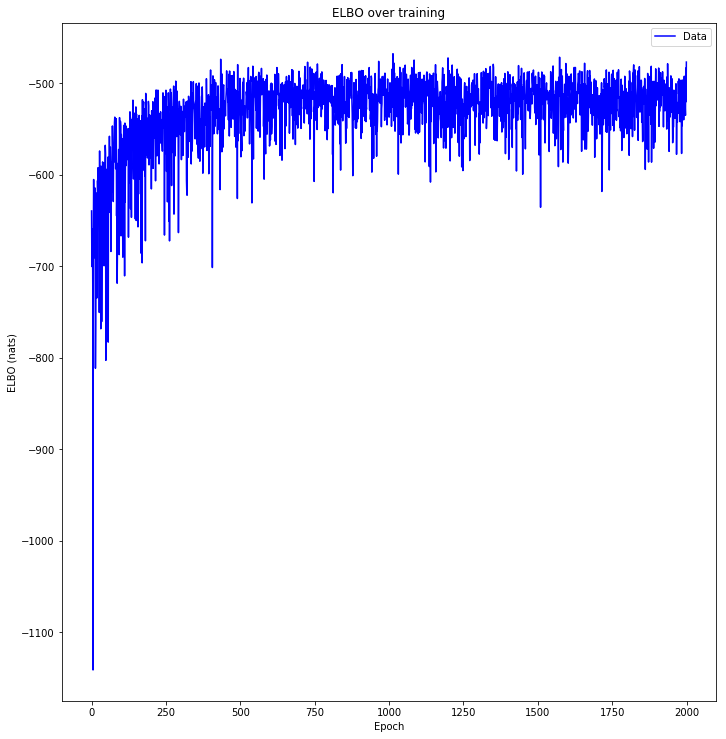

In [12]:
utils.plot_evidence_bounds(elbos)

In [13]:
ssm_smc = mcmc.reduce_resample_move_smc(ssm.SsmStep(batch_shape=particle_shape), lambda: range(50), initializer=init_ssm_proposal, moves=10)

In [14]:
_, inference, _ = ssm_smc(data=data)

In [15]:
for t in range(0, zs.shape[0]-1):
    key = generative.find(lambda k, v: str(t) in k and 'Deterministic' not in k)[0]
    z_t = 'Z_%d' % (t+1)
    accuracy = ((inference[key][z_t].value - utils.optional_to(generative[key][z_t], inference[key][z_t].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 0: 2.606889
SMC MSE at time 1: 2.174439
SMC MSE at time 2: 1.761940
SMC MSE at time 3: 1.767165
SMC MSE at time 4: 3.894429
SMC MSE at time 5: 7.225150
SMC MSE at time 6: 2.431411
SMC MSE at time 7: 1.513241
SMC MSE at time 8: 2.996331
SMC MSE at time 9: 1.873336
SMC MSE at time 10: 3.344835
SMC MSE at time 11: 4.093002
SMC MSE at time 12: 2.222390
SMC MSE at time 13: 1.499628
SMC MSE at time 14: 4.998613
SMC MSE at time 15: 1.667064
SMC MSE at time 16: 2.247518
SMC MSE at time 17: 1.781107
SMC MSE at time 18: 2.705466
SMC MSE at time 19: 2.014728
SMC MSE at time 20: 3.417790
SMC MSE at time 21: 1.858403
SMC MSE at time 22: 2.488097
SMC MSE at time 23: 1.747878
SMC MSE at time 24: 1.656159
SMC MSE at time 25: 3.049351
SMC MSE at time 26: 1.049927
SMC MSE at time 27: 3.111110
SMC MSE at time 28: 1.616617
SMC MSE at time 29: 2.086322
SMC MSE at time 30: 1.751561
SMC MSE at time 31: 7.521243
SMC MSE at time 32: 7.554909
SMC MSE at time 33: 1.791363
SMC MSE at time 34: 2.09

In [16]:
init_ssm_params

"{'folder._initializer.guide.delta__loc': 'tensor([0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516, 0.8516,\n        0.8516], grad_fn=<ExpandBackward>)', 'folder._initializer.